In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from collections.abc import Iterable 

In [3]:
from utils import plotting, transform, ingest
from forecast import stats, rf, run

In [4]:
cols = ["HOUST", "PERMIT"]
regions = ["NE", "MW", "S", "W"]

regional_hst = [f"HOUST{r}" for r in regions]
regional_permits = [f"PERMIT{r}" for r in regions]

In [5]:
raw_df = ingest.import_fred()

parsed_df = transform.standard(raw_df)

Using cached data at /mnt/c/Users/andre/tinbergen/homework/adv-macroeconometrics/week-two/data/fred_data.csv...


## Constants

In [6]:
lags = 48
end_train = "2008-01-01"

cv_params_grid = {
    'n_estimators': [5, 10, 15, 50, 100],
    'max_depth': [2, 5, 7, 9],
    'max_samples': [0.1, 0.9]
}

### Multivariate

In [7]:
houst_reg = parsed_df[regional_hst]

In [8]:
regional_data = houst_reg[regional_hst]

train = regional_data[:end_train]
test = regional_data[end_train:]

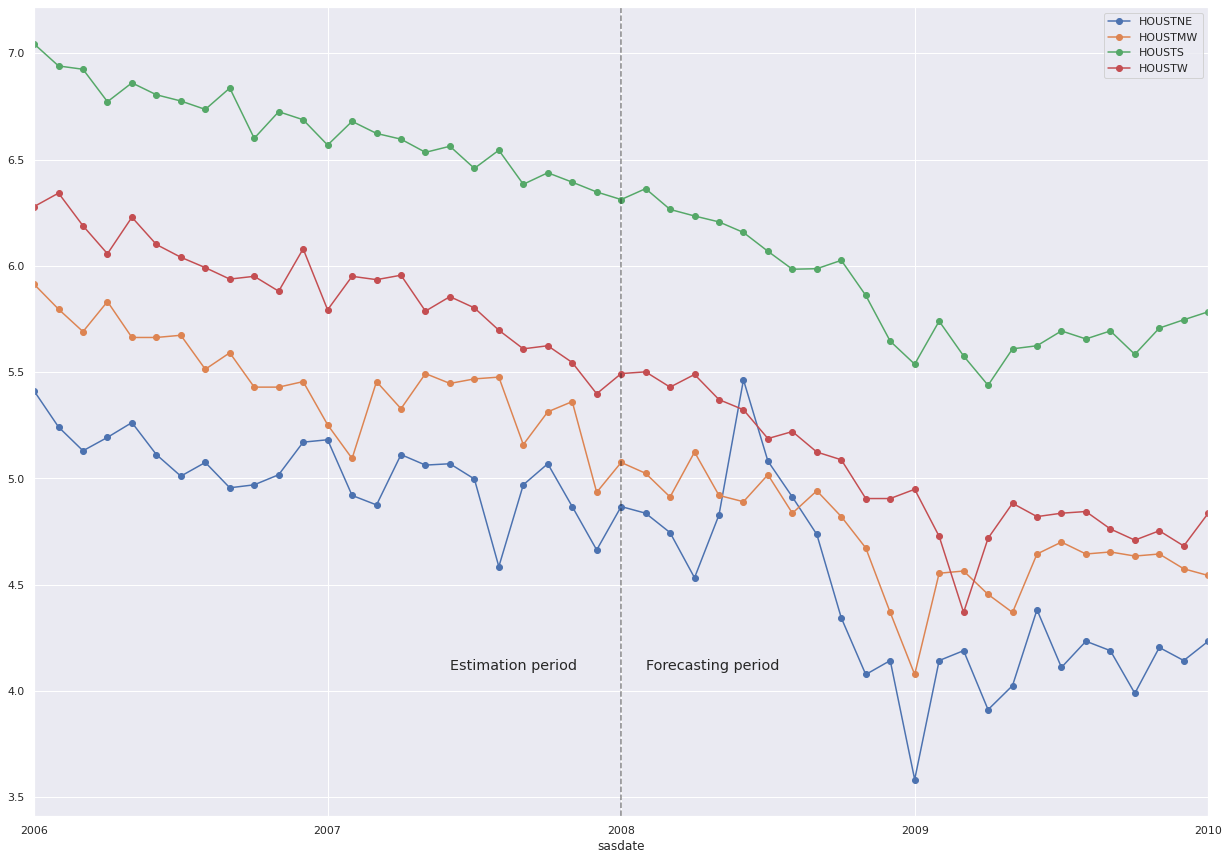

In [9]:
fig, ax = plt.subplots()
houst_reg["2006-01-01":"2010-01-01"].plot(ax = ax, marker = "o")

ax.axvline("2008-01-01", linestyle="--", c="k", alpha = 0.5)
ax.text("2008-02-01", 4.1,'Forecasting period', fontsize="large")
ax.text("2007-06-01", 4.1,'Estimation period', fontsize="large")

fig.show()

In [10]:
variables = regional_data.columns.tolist()

In [11]:
predictor = rf.make_forecaster(train, lags = lags, n_jobs = 4, verbose = 1, search_params=cv_params_grid)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:  1.2min finished


In [12]:
df_forecast = run.iterative_forecast(predictor, train, lags, periods = 24, against_baseline=True)

/mnt/c/Users/andre/tinbergen/env/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/mnt/c/Users/andre/tinbergen/env/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/mnt/c/Users/andre/tinbergen/env/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/mnt/c/Users/andre/tinbergen/env/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old

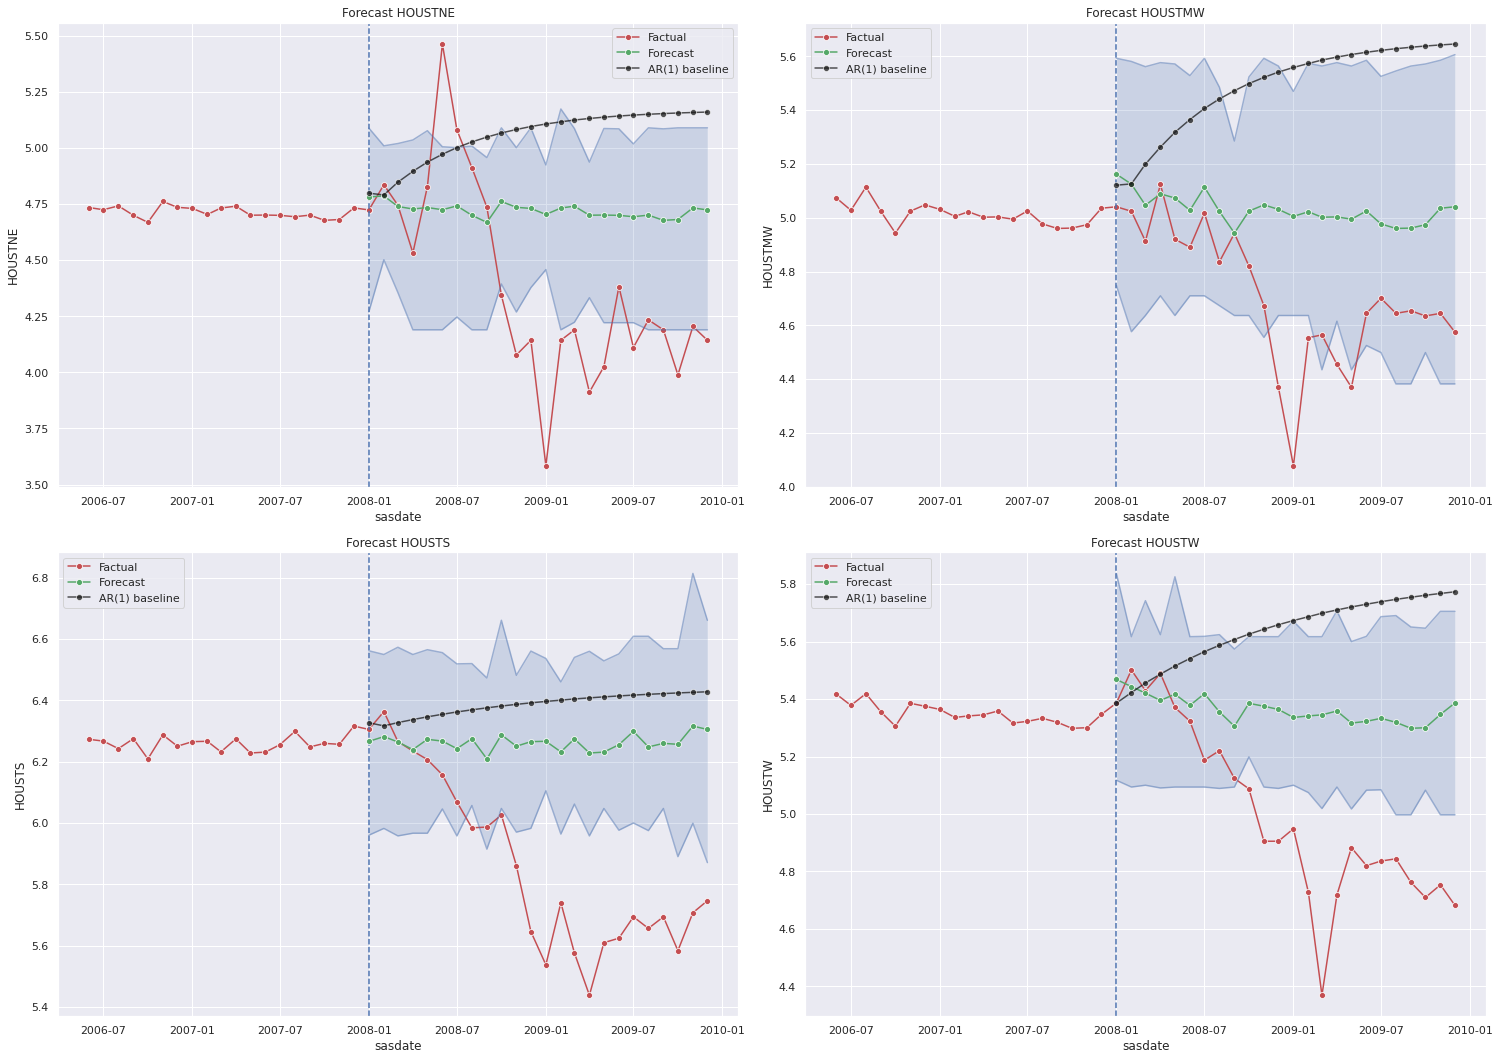

In [13]:
fig = plotting.plot_var(df_forecast, train, test, variables=regional_hst, pre_periods = 20)

fig.show()

### Exogenous variables

In [14]:
regional_permits = [f"PERMIT{r}" for r in regions]
permits_reg = parsed_df[regional_permits]

In [15]:
init_year = "1960-01-01"

In [16]:
train = houst_reg[init_year:end_train]
exog = permits_reg[init_year:]

test = houst_reg[end_train:]

In [27]:
total = pd.concat((exog[:end_train], train), axis = 1)

In [17]:
predictor = rf.make_forecaster(train, lags = lags, exog_df = exog, n_jobs = 4, verbose = 1, search_params=cv_params_grid)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  63 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 216 tasks      | elapsed:   40.4s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:  1.9min finished


In [18]:
df_forecast = run.iterative_forecast(predictor, train, lags, periods = 24, exog=exog, against_baseline=True)

/mnt/c/Users/andre/tinbergen/env/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/mnt/c/Users/andre/tinbergen/env/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/mnt/c/Users/andre/tinbergen/env/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/mnt/c/Users/andre/tinbergen/env/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old

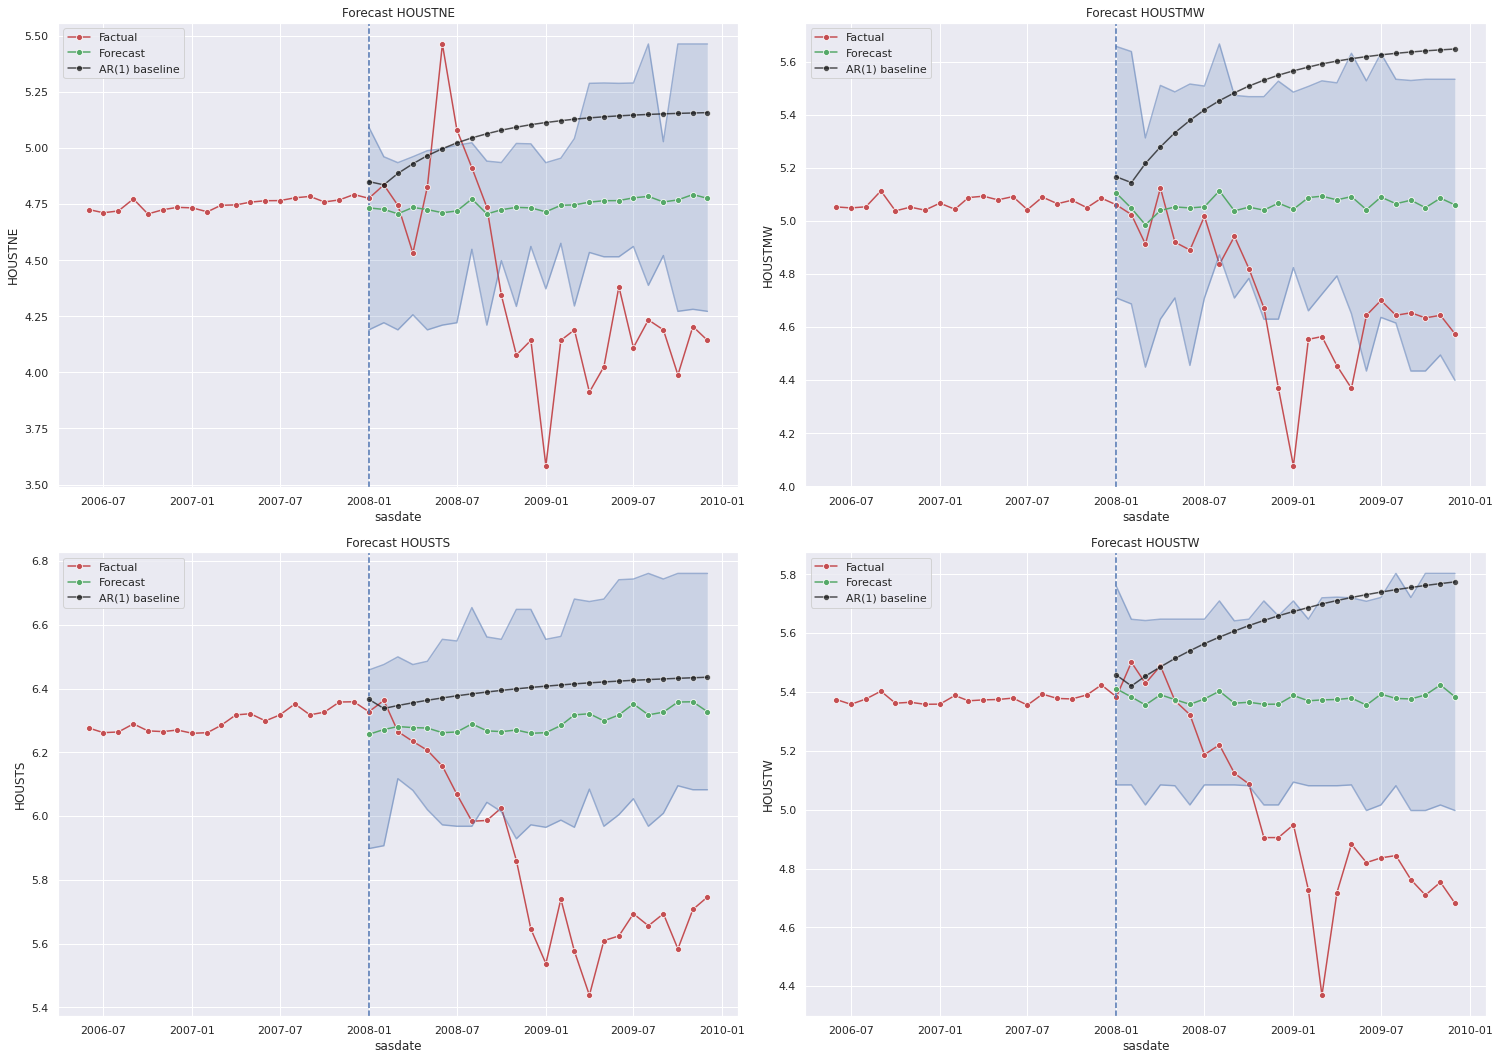

In [19]:
fig = plotting.plot_var(df_forecast, train, test, variables=regional_hst, pre_periods = 20)

fig.show()

In [20]:
%notify

<IPython.core.display.Javascript object>